0.4
0.4482758620689655
0.496551724137931
0.5448275862068965
0.5931034482758621
0.6413793103448275
0.6896551724137931
0.7379310344827587
0.7862068965517242
0.8344827586206897
0.8827586206896552
0.9310344827586207
0.9793103448275863
1.0275862068965518
1.0758620689655172
1.1241379310344828
1.1724137931034484
1.2206896551724138
1.2689655172413792
1.3172413793103448
1.3655172413793104
1.4137931034482758
1.4620689655172412
1.510344827586207
1.5586206896551724
1.6068965517241378
1.6551724137931036
1.703448275862069
1.7517241379310344
1.8


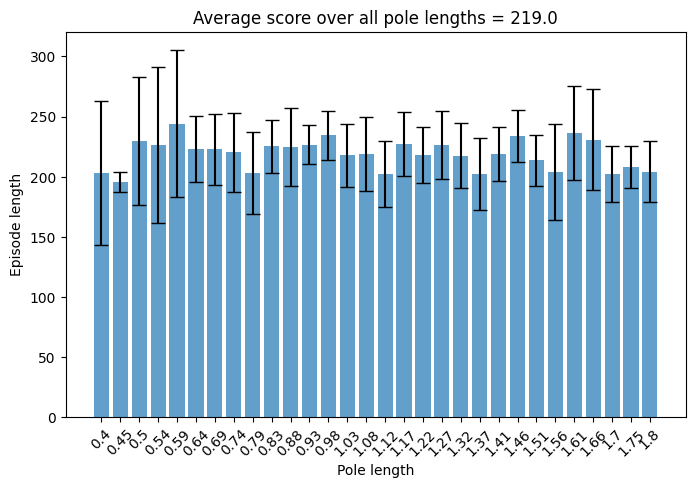

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gymnasium as gym
from collections import deque
import os
import pandas as pd
import matplotlib.pyplot as plt


# This is the 'standard' neural network
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


def bar_plot(results):
    data = results[0]

    avgs = {k: v for k, v in data.items() if k.startswith('Avg_')}
    stds = {k.replace('Avg', 'Std'): data[k.replace('Avg', 'Std')] for k in avgs.keys()}

    sorted_keys = sorted(avgs.keys(), key=lambda x: float(x.split('_')[1]))
    avg_values = [avgs[k] for k in sorted_keys]
    std_values = [stds[k.replace('Avg', 'Std')] for k in sorted_keys]

    overall_avg = np.mean(np.array(avg_values))

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(avg_values)), avg_values, yerr=std_values, capsize=5, alpha=0.7)
    plt.xticks(range(len(avg_values)), [k.split('_')[1] for k in sorted_keys])
    plt.xticks(rotation = 45)
    plt.xlabel('Pole length')
    plt.ylabel('Episode length')
    plt.title(f'Average score over all pole lengths = {round(overall_avg, 0)}')

    plt.savefig("bar_plot.png")
    plt.show()


# Test the agent after training
def test_pole_length(env, q_network):
    """
    This function runs your trained network on a specific pole length
    You are not allowed to change this function
    """

    wind = 25
    state = env.reset()[0]
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    done = False
    total_reward = 0


    while not done:

        action = q_network(state).argmax().item()
        next_state, reward, done, _, __ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
        state = next_state
        total_reward += reward

        if total_reward >= 500 and total_reward <= 1000:
            if total_reward % wind == 0:

                env.unwrapped.force_mag = 75

        if total_reward > 1000:
            env.unwrapped.force_mag = 25 + (0.01 * total_reward)

    return total_reward



def test_script():
    """
    Function that simulates the trained NN over 30 different pole lengths, 10 times per length.
    """

    pole_lengths = np.linspace(0.4, 1.8, 30)
    all_results = []

    # import here your trained neural network
    trained_nn = 'dqn_curriculum_short_to_long.pth'

    results = {}
    total_score = 0

    for length in pole_lengths:
        print(length)

        pole_score = []

        for x in range(10):

            env = gym.make('CartPole-v1')
            env.unwrapped.length = length

            state_dim = env.observation_space.shape[0]
            action_dim = env.action_space.n
            loaded_model = QNetwork(state_dim, action_dim)
            loaded_model.load_state_dict(torch.load("weights/" + trained_nn, weights_only=True))

            # Switch to evaluation mode
            loaded_model.eval()  # Use for inference
            score = test_pole_length(env, loaded_model)
            pole_score.append(score)

        mean_score = np.mean(np.array(pole_score))
        std_score = np.std(np.array(pole_score))

        total_score += mean_score

        results[f"Avg_{round(length, 2)}"] = mean_score  # Store just the mean
        results[f"Std_{round(length, 2)}"] = std_score  # Store std separately

    results["Total"] = total_score  # Store just the mean
    all_results.append(results)

    bar_plot(all_results)

    # Convert list to DataFrame
    df = pd.DataFrame(all_results)
    df.to_excel("experiment_results.xlsx", index=False)

if __name__ == "__main__":
    test_script()